# EKF Implementation

The goal of this EKF filter is to measure roll from the boat using the accelerometer and gyrometer.

The state contains the following:

* Roll
* Roll rate

In [46]:
import sympy as sp
sp.init_printing()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
theta, omega = sp.symbols('\Theta \omega')
state = sp.Matrix([theta, omega])
dt = sp.symbols('\Delta_t')

# Prediction step

The prediction step assumes constant angular velocity.

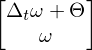

In [3]:
dx = sp.Matrix([omega, 0])
g = state + dt * dx
g

# Estimating the variance

Basically to find a realistic value for the variance, we will assume that 3 $\sigma$ contains all the observed samples (> 99% is almost all).
Then we can pick a maximum value for the angular acceleration. For example, we could say that the boat will not go faster than from fully upright to on its flank in a second.
Assuming it does so at constant acceleration:

\begin{equation}
90° = \frac{1}{2} \alpha_{max} t^2
\end{equation}

Now that we have the maximum acceleration, the maximum error in speed is $3 \sigma_{\omega} = \Delta_t \alpha_{max}$ and in position it is $3 \sigma_{\theta} = \frac{1}{2} \alpha_{max} \Delta_t^2$.

Numerically this gives

In [4]:
FREQUENCY = 100.
delta_angle, delta_t = np.radians(90), 1
a_max = 2 * delta_angle / (delta_t ** 2)
sigma_speed = (a_max / FREQUENCY) / 3
sigma_position = (0.5 * a_max / (FREQUENCY**2)) / 3
print("Sigma speed: {:.3f}, position: {:.6f}".format(sigma_speed, sigma_position))

Sigma speed: 0.010, position: 0.000052


# Measurement step

* The acceleration should be equal to the gravity projected on the estimated rotation
* The velocity should be equal to the state velocity

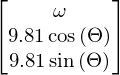

In [17]:
gravity = 9.81
gz = sp.sin(theta) * gravity
gy = sp.cos(theta) * gravity
h = sp.Matrix([omega, gy, gz])
h

## Estimating the variance of the measurements

For the gyrometer it is (should be) easy.
We can directly take the RMS value in the datasheet and use it as the standard deviation.

In [18]:
sigma_gyro = 8e-3 * 9.81 # at 94 hz (MPU9250 datasheet, p. 9)

For the accelerometer though, we need to take into account the centrifugal acceleration that the boat will have.
To compute those I took the case of a boat circling on a 5 meter radius at a speed of 10 m/s (generous) and took this as my maximum. We know that the acceleration is given by $V^2/R$, which is:

In [252]:
V = 5
R = 10
a = V**2/R
sigma_acceleration_x = a / 3
print("acceleration is {:3f}/s/s".format(a))
print("Simga on horizontal acceleration is {:.3f} m/s/s".format(sigma_acceleration_x))

acceleration is 2.500000/s/s
Simga on horizontal acceleration is 0.833 m/s/s


For the vertical acceleration we will also have some noise. I will assume that the worst case is a free fall, meaning $3 \sigma = 9.81$, therefore:

In [253]:
sigma_acceleration_y = 0.981 / 3

# Turning it into a kalman filter

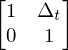

In [254]:
g.jacobian(state)

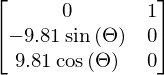

In [255]:
h.jacobian(state)

In [256]:
state

In [262]:
import ekf
u = [] # no control input
g_num = sp.lambdify([state, u], g.replace(dt, 1/FREQUENCY), 'numpy')
G_num = sp.lambdify([state, u], g.jacobian(state).replace(dt, 1/FREQUENCY), 'numpy')
h_num = sp.lambdify([state], h, 'numpy')
H_num = sp.lambdify([state], h.jacobian(state), 'numpy')

R = np.diag([sigma_position**2, sigma_speed**2])
Q = np.array([[sigma_gyro**2, sigma_acceleration_x**2, sigma_acceleration_y**2]])

predictor = ekf.Predictor(g_num, G_num, R)
corrector = ekf.Corrector(h_num, H_num, Q)

# Simulation

For the first simulation, we can simply put it on a sine wave.

In [263]:
boat_frequency = 1 / 5
boat_amplitude = np.radians(10)
traj_theta = lambda t: boat_amplitude * np.sin(boat_frequency * np.pi * t)
traj_omega = lambda t: boat_amplitude * np.cos(boat_frequency * np.pi * t)

def trajectory(duration):
    t = 0.
    while t < duration:
        yield traj_theta(t), traj_omega(t)
        t += 1 / FREQUENCY

In [264]:
def simulate():
    state_history = []
    truth_history = []
    state = np.array([0, 0])
    covar = np.array([0.1, 0.1])
    for theta, omega in trajectory(10.):
        state, covar = predictor(state, covar, [])
        noise = np.random.normal(scale=[sigma_gyro**2, sigma_acceleration_x**2, sigma_acceleration_y**2], size=(1, 3))
        noise = noise.transpose()
        measurement = h_num([np.array([theta, omega])]) + noise
        state, covar = corrector(state, covar, measurement)
        state_history.append(state)
        truth_history.append([theta, omega])
    return state_history, truth_history

In [265]:
estimation, truth = simulate()

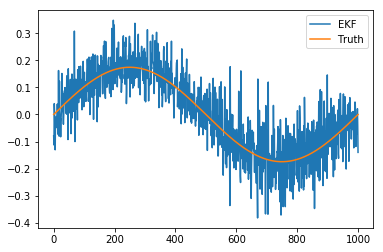

In [266]:
plt.plot([s[0] for s in estimation])
plt.plot([s[0] for s in truth])
plt.legend(['EKF', 'Truth'])
plt.show()